# NLP Lab7 - NER and Classification with LLMs

**Author: Bartłomiej Jamiołkowski**

The exercise demonstrates how to leverage Large Language Models for NER and text classification tasks, comparing their performance with traditional approaches.

In [1]:
from datasets import load_dataset
from langchain.llms import Ollama
from langchain import PromptTemplate, FewShotPromptTemplate
from tqdm import tqdm

import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import psutil
import json
import time

import warnings
warnings.filterwarnings('ignore')

## Task 1

Install and configure [OLLama](https://ollama.com/) with an appropriate LLM model (e.g. models from: Llama, Mistral, Bielik, Phi families). Rather not use models above 10B paramters.
Sample LLM run command, when OLLama is installed: `ollama run phi3:3.8b`

In [2]:
ollama = Ollama(base_url = 'http://localhost:11434', model = 'gemma2')

## Task 2

Take 1 thousand random passages from the FIQA-PL corpus. INFO: You can play with new dataset, but it will be necessary to create baseline results (next excersise).

In [3]:
fiqa_pl = load_dataset('clarin-knext/fiqa-pl', 'corpus')
fiqa_pl_df = fiqa_pl['corpus'].to_pandas()

In [4]:
random_passages_df = fiqa_pl_df.drop(columns = ['title']).sample(n = 1000)
random_passages_df.head()

,_id,text
13320,137078,"„Oto, co się wydarzy: w ostatniej chwili „odkr..."
17674,182930,"„Jak wcześniej odpowiedziałem, rozwiązaniem je..."
41776,435060,"„X-Post, do którego odwołuje się [/r/irstudies..."
57613,599715,"„To najlepszy tl;dr, jaki mogłem stworzyć, [or..."
3784,39436,"„Najbardziej podstawową odpowiedzią jest to, ż..."


At this point, I am saving random passages in Parquet format because every time I run the notebook, I change the random passages. If I did not do that, I would constantly have to recreate the ground truth dataset.

In [5]:
# random_passages_df.to_parquet('random_passages.parquet')

In [6]:
random_passages_df = pd.read_parquet('random_passages.parquet')
random_passages_df.head()

,_id,text
17601,182065,Przykro z powodu twojej straty. Jeśli pieniądz...
36684,381489,"Och, więc nienawidzę biednych, bo chcę tworzyć..."
15623,161155,Czy zasada prania ma do tego zastosowanie? Nie...
10665,109837,„hahah” „Delta nazwała 737-7 MAX nieekonomiczn...
15566,160611,Tylko do Twojej wiadomości z korzyścią dla prz...


## Task 3

As baseline use traditional NER methods from lab 7 - SpaCy.

In [7]:
polish_nlp = spacy.load('pl_core_news_sm')

In [8]:
full_random_passages_text_20 = ' '.join(random_passages_df['text'][:20])

At this part of the laboratory, I have to refer to **Task 7**, because I need to start calculating and gathering performance metrics such as accuracy, speed and resource usage. Therefore, I am going to: manually annotate 20 passages for ground truth, create a function to calculate memory usage and implement time measurement.

In [9]:
ground_truth = [{'entity': '30 dni', 'category': 'time'}, {'entity': 'Delta', 'category': 'orgName'}, {'entity': 'kanadyjskim', 'category': 'placeName'},
                {'entity': 'Sears', 'category': 'orgName'}, {'entity': 'Kanadzie', 'category': 'placeName'}, {'entity': 'Sears', 'category': 'orgName'},
                {'entity': 'ostatnich trzech lat', 'category': 'time'}, {'entity': 'Sears', 'category': 'orgName'},
                {'entity': 'SEC', 'category': 'orgName'}, {'entity': 'Dwuletni', 'category': 'time'}, {'entity': 'Group Homes', 'category': 'orgName'},
                {'entity': 'Halfway Homes', 'category': 'orgName'}, {'entity': 'ICF / MR Homes', 'category': 'orgName'}, 
                {'entity': ' Disability Homes', 'category': 'orgName'}, {'entity': 'rocznie', 'category': 'time'}, 
                {'entity': 'Searsa', 'category': 'orgName'}, {'entity': 'Amazon', 'category': 'orgName'}, {'entity': 'w ciągu roku', 'category': 'time'},
                {'entity': 'Kansas', 'category': 'placeName'}, {'entity': 'BA (Executive Club)', 'category': 'orgName'}, 
                {'entity': 'Air Berlin', 'category': 'orgName'}, {'entity': 'American Airlines', 'category': 'orgName'}, 
                {'entity': 'Iberia', 'category': 'orgName'}, {'entity': 'USA', 'category': 'placeName'}, {'entity': 'UE', 'category': 'orgName'}, 
                {'entity': 'BA', 'category': 'orgName'}, {'entity': 'American Airlines', 'category': 'orgName'}, 
                {'entity': 'USA', 'category': 'placeName'}, {'entity': 'Qantas', 'category': 'orgName'}, 
                {'entity': 'Daleki Wschód', 'category': 'geogName'}, {'entity': 'BA', 'category': 'orgName'}, {'entity': 'IRS', 'category': 'orgName'},
                {'entity': 'rok podatkowy', 'category': 'time'}, {'entity': 'roku podatkowego', 'category': 'time'}, 
                {'entity': 'rok kalendarzowy', 'category': 'time'}, {'entity': '500', 'category': 'time'}, 
                {'entity': '100 lat temu', 'category': 'time'}, {'entity': '100-500 lat', 'category': 'time'}, 
                {'entity': 'ostatnich 100 latach', 'category': 'time'}, {'entity': 'ostatnich 30-40 latach', 'category': 'time'}]

In [10]:
def find_start_end_indices(ner_json, fulltext):
    ner_json_with_indices = []
    current_index = 0

    for entity_dict in ner_json:
        start_char = fulltext.find(entity_dict['entity'], current_index)
        updated_entity_dict = entity_dict.copy()

        if start_char == -1:
            updated_entity_dict['start_char'] = np.nan
            updated_entity_dict['end_char'] = np.nan
        else:
            end_char = start_char + len(entity_dict['entity'])
            updated_entity_dict['start_char'] = start_char
            updated_entity_dict['end_char'] = end_char
            current_index = end_char

        ner_json_with_indices.append(updated_entity_dict)

    return ner_json_with_indices

In [11]:
ground_truth = find_start_end_indices(ground_truth, full_random_passages_text_20)
print(ground_truth)

[{'entity': '30 dni', 'category': 'time', 'start_char': 888, 'end_char': 894}, {'entity': 'Delta', 'category': 'orgName', 'start_char': 976, 'end_char': 981}, {'entity': 'kanadyjskim', 'category': 'placeName', 'start_char': 1174, 'end_char': 1185}, {'entity': 'Sears', 'category': 'orgName', 'start_char': 2454, 'end_char': 2459}, {'entity': 'Kanadzie', 'category': 'placeName', 'start_char': 2528, 'end_char': 2536}, {'entity': 'Sears', 'category': 'orgName', 'start_char': 2596, 'end_char': 2601}, {'entity': 'ostatnich trzech lat', 'category': 'time', 'start_char': 2663, 'end_char': 2683}, {'entity': 'Sears', 'category': 'orgName', 'start_char': 2713, 'end_char': 2718}, {'entity': 'SEC', 'category': 'orgName', 'start_char': 3623, 'end_char': 3626}, {'entity': 'Dwuletni', 'category': 'time', 'start_char': 3900, 'end_char': 3908}, {'entity': 'Group Homes', 'category': 'orgName', 'start_char': 4106, 'end_char': 4117}, {'entity': 'Halfway Homes', 'category': 'orgName', 'start_char': 4119, 'en

The above list of tuples contains the first 20 manually annotated passages from random texts. I carefully studied each sentence with the assistance of an LLM to avoid human errors.

In [12]:
ground_truth_df = pd.DataFrame(ground_truth).rename(columns = {'entity': 'entity_true', 'category': 'label_true'})
ground_truth_df.head()

,entity_true,label_true,start_char,end_char
0,30 dni,time,888,894
1,Delta,orgName,976,981
2,kanadyjskim,placeName,1174,1185
3,Sears,orgName,2454,2459
4,Kanadzie,placeName,2528,2536


I am going to use this list in evaluation function created from scratch. I enhance evaluation approach known as: 'Strict Evaluation Method' theoretically desribed in this [Medium article](https://rumn.medium.com/nervaluate-the-ultimate-way-for-benchmarking-ner-models-b29e83fbae95). This approach is very strict, meaning that a result is marked as correct (COR) only, when all entities and labels are the same. Therefore, I do not expect high accuracies.

In [13]:
def strict_evaluation_ner(ground_truth_df: pd.DataFrame, predictions_df: pd.DataFrame) -> dict:
    evaluation_df = pd.merge(
        ground_truth_df, 
        predictions_df,
        left_on = ['start_char', 'end_char'], 
        right_on = ['start_char', 'end_char'], 
        how = 'outer').sort_values(by = 'start_char').drop(columns = ['start_char', 'end_char'])

    display(evaluation_df.head())
    
    metrics = {'COR': 0, 'INC': 0, 'MIS': 0, 'SPU': 0, 'POS': 0, 'ACT': 0, 'Precision': None, 'Recall': None, 'F1': None}

    for _, row in evaluation_df.iterrows():
        if row['entity_true'] == row['entity_pred'] and row['label_true'] == row['label_pred']:
            metrics['COR'] += 1
        elif pd.isna(row['entity_true']) and pd.isna(row['label_true']):
            metrics['SPU'] += 1
        elif pd.isna(row['entity_pred']) or pd.isna(row['label_pred']):
            metrics['MIS'] += 1
        else:
            metrics['INC'] += 1

    metrics['POS'] = metrics['COR'] + metrics['INC'] + metrics['MIS']
    metrics['ACT'] = metrics['COR'] + metrics['INC'] + metrics['SPU']
    metrics['Precision'] = metrics['COR'] / metrics['ACT']
    metrics['Recall'] = metrics['COR'] / metrics['POS']
    metrics['F1'] = 2 * metrics['Precision'] * metrics['Recall'] / (metrics['Precision'] + metrics['Recall'])
    
    return metrics

Below is an implemented function that returns the measured memory usage in KB.

In [14]:
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024

First, Taditional NER (SpaCy) speed and memory usage are measured.

In [83]:
start_time = time.time()
start_memory = memory_usage()
named_entities_spacy = [{'entity': entity.text, 'category': entity.label_} for entity in polish_nlp(full_random_passages_text_20).ents]
end_memory = memory_usage()
end_time = time.time()

total_time = end_time - start_time
used_memory = end_memory - start_memory

In [84]:
named_entities_spacy = find_start_end_indices(named_entities_spacy, full_random_passages_text_20)
named_entities_spacy_df = pd.DataFrame(named_entities_spacy).rename(columns = {'entity': 'entity_pred', 'category': 'label_pred'})
named_entities_spacy_df.to_parquet('named_entities_spacy_results.parquet')
named_entities_spacy_df.head()

,entity_pred,label_pred,start_char,end_char
0,Sears,placeName,2454,2459
1,Kanadzie,placeName,2528,2536
2,Sears,persName,2596,2601
3,Sears,placeName,2713,2718
4,NQO,persName,3265,3268


In [85]:
named_entities_spacy_df = pd.read_parquet('named_entities_spacy_results.parquet')

In [86]:
named_entities_spacy_performance = {'speed': total_time, 'resource usage': used_memory}
named_entities_spacy_performance.update(strict_evaluation_ner(ground_truth_df, named_entities_spacy_df))
print(f'Performance of Traditional NER (SpaCy): {named_entities_spacy_performance}')

,entity_true,label_true,entity_pred,label_pred
0,30 dni,time,NaN,NaN
1,Delta,orgName,NaN,NaN
2,kanadyjskim,placeName,NaN,NaN
3,Sears,orgName,Sears,placeName
4,Kanadzie,placeName,Kanadzie,placeName


Performance of Traditional NER (SpaCy): {'speed': 0.26978087425231934, 'resource usage': 20.0, 'COR': 10, 'INC': 6, 'MIS': 24, 'SPU': 13, 'POS': 40, 'ACT': 29, 'Precision': 0.3448275862068966, 'Recall': 0.25, 'F1': 0.2898550724637681}


## Task 4

Design prompts for the LLM to:
   * Identify named entities in text
   * Classify them into predefined categories (person, organization, location, e.)

First, I design a zero-shot prompt, which will serve as a baseline for further prompt development. In this prompt, I am applying a combination of techniques, including Clear Instructions, Domain Prompts, and Chain-of-Thought.

The technique known as Clear Instructions is based on two or three prompts:
- System: This prompt is used to provide instructions,
- User: This prompt provides context and data,
- Assistant: This prompt is optional (used in few-shot prompting) and is responsible for providing examples.

The Domain Prompts technique allows the user to include domain-specific instructions.

Chain-of-Thought is a prompting technique in which each given task is followed by an intermediate reasoning step that leads to the final answer.

In [87]:
zero_shot_template = '''
<start_of_turn>user
You are an AI assistant with expertise in Named Entity Recognition (NER). Find named entities as they appear in the given text. 
Every found named entity must be given with only one predefined category: 'date', 'geogName', 'orgName', 'persName', 'placeName' or 'time'.
Return results in JSON format.

See further instructions below for each category:

- 'date': Refers to specific calendar points or periods such as day, month, year, season, etc.
- 'geogName': Refers to geographical names like continents, regions, oceans, rivers, seas, mountains, etc.
- 'orgName': Refers to names of organizations, companies, brands, institutions, government bodies, federations, agencies, associations, etc.
- 'persName': Refers to personal names such as first names, last names, full names, etc.
- 'placeName': Refers to names of locations such as countries, cities, towns, streets, districts, etc.
- 'time': Refers to any references to hours, minutes, seconds, periods of time, or time intervals.

Let's think step-by-step.

The expected result should look like this:
1. Extract named entities exactly as they appear in the given text.
2. You are forbidden to create new categories.
3. You are forbidden to comment or retun anything else than result in JSON format. 
4. Provide the results in JSON format, where each element in the list is a dictionary with the following structure:
   - "entity": The exact text of the one named entity.
   - "category": The predefined one category of the one named entity.

Given text: {text}
<end_of_turn>
<start_of_turn>model
'''

Below are examples and fragments of a Few-shot prompt gathered together to maintain order. For the Few-shot prompt, I have to split the original prompt into parts, because the langchain prompt template requires this. 

I also selected examples from a subset of the FIQUA-PL dataset, which is distinct from the random passages subdataset. 
The selected examples are interesting, as they allow me to create answers for multiple categories. In these tasks, I am using the same categories returned by spaCy for comparison purposes.

In [88]:
examples = [
    {
        'text': '''Tak, instynktownie wiedziałem, że Bliski Wschód prawdopodobnie nie będzie tym, nawet bez znajomości Jacka o finansach. Więc z punktu
        widzenia Europy patrzymy na Frankfurt i Londyn? A co z Azją, co z Hongkongiem? Biorąc pod uwagę, że już teraz staje się centrum instrumentacji
        między różnymi systemami finansowymi i bliskością Azji Południowo-Wschodniej (także jest częścią ChRL umożliwiającą bezpośredni dostęp do Chin,
        ale nie działa zgodnie z takimi samymi ograniczeniami, jak Szanghaj w ramach umowy „Dwa kraje, jeden system”, czy postrzegasz to jako przyszłe
        główne centrum islamskich finansów? A może to wszystko będzie stłoczone w Singapurze?''', 
        'output':'''
        [
            {{
                "entity": "Bliski Wschód",
                "category": "geogName"
            }}, 
            {{
                "entity": "Jacka",
                "category": "persName"
            }}, 
            {{
                "entity": "Europy",
                "category": "geogName"
            }}, 
            {{
                "entity": "Frankfurt",
                "category": "placeName"
            }}, 
            {{
                "entity": "Londyn",
                "category": "placeName"
            }},
            {{
                "entity": "Azją",
                "category": "geogName"
            }}, 
            {{
                "entity": "Hongkongiem",
                "category": "placeName"
            }}, 
            {{
                "entity": "Azji Południowo-Wschodniej",
                "category": "geogName"
            }}, 
            {{
                "entity": "ChRL",
                "category": "placeName"
            }}, 
            {{
                "entity": "Chin",
                "category": "placeName"
            }}, 
            {{
                "entity": "Szanghaj",
                "category": "placeName"
            }}, 
            {{
                "entity": "Singapurze",
                "category": "placeName"
            }}
        ]'''
    }, 
    {
        'text': '''Nie ma ceny, którą którakolwiek z dwóch stron płaci z góry za zawarcie
        umowy. Użyty język jest taki, że agent, który zobowiązał się do otrzymania dostawy aktywów bazowych, miał kupić kontrakt. Mówi się, że agent,
        który zobowiązuje się dokonać dostawy, sprzedał umowę. Odpowiedz więc na swoje pytanie, kupując 1 czerwca kontrakt futures po cenie 100 USD,
        z terminem zapadalności 1 sierpnia, oznacza to, że zobowiązujesz się zapłacić 100 USD za aktywa bazowe 1 sierpnia. Nie musisz nic płacić z góry.
        Cena kontraktu futures jest po prostu tym, co kontrakt przewiduje, że aktywa bazowe będą wymieniać ręce.''', 
        'output':'''
        [
            {{
                "entity": "1 czerwca", 
                "category": "date"
            }}, 
            {{
                "entity": "1 sierpnia",
                "category": "date"
            }}, 
            {{
                "entity": "1 sierpnia",
                "category": "date"
            }}
        ]'''
    },
    {
        'text': '''W zależności od tego, w jakim stanie mieszkasz w Stanach Zjednoczonych, Twój kanadyjski broker może być w stanie sprzedawać produkty
        w ramach istniejącego RRSP. Mam RRSP w Kanadzie za pośrednictwem TD Waterhouse, a oni właśnie wysłali mi ostatni list wyjaśniający, że mogą
        obsługiwać moje kanadyjskie RRSP zgodnie z prawem stanu Tennessee (gdzie mieszkam). Notatka dalej wyraźnie stwierdzała, że nie podlegają
        one amerykańskim regulacjom maklerów-dealerów ani ustawom o papierach wartościowych/przepisom ustawy TN o papierach wartościowych.
        Ponadto stwierdzają, że kanadyjskie RRSP nie są regulowane przez amerykańskie przepisy dotyczące papierów wartościowych, a papiery wartościowe
        oferowane i sprzedawane kanadyjskim planom są zwolnione z rejestracji w SEC. Kiedy dzwonię do TD w celu dokonania transakcji, po prostu pytam
        o brokera z Kanady/USA i to on zawiera dla mnie sprzedaż. Corocznie deklaruję moje RRSP zarówno do IRS w ramach traktatu RRSP, jak i poprzez
        raportowanie FBAR.''', 
        'output':'''
        [
            {{
                "entity": "Stanach Zjednoczonych",
                "category": "placeName"
            }}, 
            {{
                "entity": "Kanadzie", 
                "category": "placeName"
            }}, 
            {{
                "entity": "TD Waterhouse",
                "category": "orgName"
            }}, 
            {{
                "entity": "Tennessee",
                "category": "placeName"
            }}, 
            {{
                "entity": "SEC", 
                "category": "orgName"
            }}, 
            {{
                "entity": "TD",
                "category": "orgName"
            }}, 
            {{
                "entity": "Kanady",
                "category": "placeName"
            }}, 
            {{
                "entity": "USA",
                "category": "placeName"
            }}, 
            {{
                "entity": "IRS", 
                "category": "orgName"
            }}
        ]'''
    },
    {
        'text': '''Aby to zrobić, musisz kupić kartę podarunkową Amazon od innego sprzedawcy internetowego, który akceptuje PayPal, a następnie użyć
        karty podarunkowej Amazon na stronie Amazon. Istnieją dziesiątki (jeśli nie setki) witryn, które sprzedają karty podarunkowe Amazon online,
        które akceptują PayPal.''',
        'output': '''
        [
            {{
                "entity": "Amazon", 
                "category": "orgName"
            }}, 
            {{
                "entity": "PayPal", 
                "category": "orgName"
            }}, 
            {{
                "entity": "Amazon",
                "category": "orgName"
            }}, 
            {{
                "entity": "Amazon",
                "category": "orgName"
            }}, 
            {{
                "entity": "Amazon",
                "category": "orgName"
            }},
            {{
                "entity": "PayPal",
                "category": "orgName"
            }}
        ]'''
    }
]

The FewShotPromptTemplate from LangChain requires several parameters, such as: examples (listed above), example_prompt, prefix and suffix. The rest of these parameter templates are defined below. Some of the prompts need to be modified because the LLM behaves differently when using Few-shot compared to Zero-shot prompts.

In [89]:
example_template = '''
Example
Text: {text}
Output: {output}
'''

In [90]:
prefix = '''
<start_of_turn>user
You are an AI assistant with expertise in Named Entity Recognition (NER). Find named entities as they appear in the given text. 
Every found named entity must be given with only one predefined category: 'date', 'geogName', 'orgName', 'persName', 'placeName' or 'time'.
Return results in JSON format.

See further instructions below for each category:

- 'date': Refers to specific calendar points or periods such as day, month, year, season, etc.
- 'geogName': Refers to geographical names like continents, regions, oceans, rivers, seas, mountains, etc.
- 'orgName': Refers to names of organizations, companies, brands, institutions, government bodies, federations, agencies, associations, etc.
- 'persName': Refers to personal names such as first names, last names, full names, etc.
- 'placeName': Refers to names of locations such as countries, cities, towns, streets, districts, etc.
- 'time': Refers to any references to hours, minutes, seconds, periods of time, or time intervals.

Let's think step-by-step.

The expected result should look like this:
1. Extract named entities exactly as they appear in the given text.
2. You are forbidden to create new categories.
3. You are forbidden to comment or retun anything else than result in JSON format. 
4. Provide the results in JSON format, where each element in the list is a dictionary with the following structure:
   - "entity": The exact text of the one named entity.
   - "category": The predefined one category of the one named entity.

Examples:
'''

In [91]:
suffix = '''
Given text: {text}
<end_of_turn>
<start_of_turn>model
'''

## Task 5

Implement prompt variations to compare performance:
   * Zero-shot prompting
   * Few-shot prompting with 3-5 examples.)

In [92]:
def ollama_ner(prompt_template, textual_data: pd.DataFrame) -> list:
    named_entities_llm = []
    
    for index, row in tqdm(textual_data.iterrows(), total = len(textual_data), desc = 'Searching...'):
        response = ollama.invoke(prompt_template.format(text = row['text']), temperature = 0.0)
        
        if not response.strip():
            print(f'Warning: Empty response for DataFrame index {index}. Skipping.')
            continue
        
        try:
            named_entities_row = json.loads(response)
            named_entities_llm += named_entities_row
        except json.JSONDecodeError:
            pass
    
    return named_entities_llm

First, I create a Zero-shot prompt using the zero_shot_template developed in the previous task.

In [93]:
zero_shot_prompt_template = PromptTemplate(input_variables = ['text'], template = zero_shot_template)

In [94]:
start_time = time.time()
start_memory = memory_usage()
named_entities_zero_shot_llm = ollama_ner(zero_shot_prompt_template, random_passages_df[:20])
end_memory = memory_usage()
end_time = time.time()

total_time = end_time - start_time
used_memory = end_memory - start_memory

Searching...: 100%|██████████| 20/20 [05:25<00:00, 16.26s/it]


In [95]:
named_entities_zero_shot_llm = find_start_end_indices(named_entities_zero_shot_llm, full_random_passages_text_20)
named_entities_zero_shot_llm_df = pd.DataFrame(named_entities_zero_shot_llm).rename(columns = {'entity': 'entity_pred', 'category': 'label_pred'})
named_entities_zero_shot_llm_df.to_parquet('named_entities_zero_shot_llm_results.parquet')
named_entities_zero_shot_llm_df.head()

,entity_pred,label_pred,start_char,end_char
0,EDYCJA,orgName,211.0,217.0
1,księgowości,orgName,522.0,533.0
2,biznesie,orgName,536.0,544.0
3,13 500 USD,date,748.0,758.0
4,14 250 USD,date,787.0,797.0


In [96]:
named_entities_zero_shot_llm_performance = {'speed': total_time, 'resource usage': used_memory}
named_entities_zero_shot_llm_performance.update(strict_evaluation_ner(ground_truth_df, named_entities_zero_shot_llm_df))
print(f'Performance of Zero-shot prompting in LLM: {named_entities_zero_shot_llm_performance}')

,entity_true,label_true,entity_pred,label_pred
0,NaN,NaN,EDYCJA,orgName
1,NaN,NaN,księgowości,orgName
2,NaN,NaN,biznesie,orgName
3,NaN,NaN,13 500 USD,date
4,NaN,NaN,14 250 USD,date


Performance of Zero-shot prompting in LLM: {'speed': 325.2818932533264, 'resource usage': 44.0, 'COR': 16, 'INC': 3, 'MIS': 21, 'SPU': 34, 'POS': 40, 'ACT': 53, 'Precision': 0.3018867924528302, 'Recall': 0.4, 'F1': 0.3440860215053763}


In [98]:
# with open('named_entities_zero_shot_llm_performance.json', 'w', encoding = 'utf-8') as json_file:
#     json.dump(named_entities_zero_shot_llm_performance, json_file, ensure_ascii = False, indent = 4)

In [99]:
with open('named_entities_zero_shot_llm_performance.json', 'r', encoding = 'utf-8') as json_file:
    named_entities_zero_shot_llm_performance = json.load(json_file)

In [100]:
print(named_entities_zero_shot_llm_performance)

{'speed': 325.2818932533264, 'resource usage': 44.0, 'COR': 16, 'INC': 3, 'MIS': 21, 'SPU': 34, 'POS': 40, 'ACT': 53, 'Precision': 0.3018867924528302, 'Recall': 0.4, 'F1': 0.3440860215053763}


Then, I crete Few-shot prompt using predefined templates placed in previous task.

In [101]:
example_prompt = PromptTemplate(input_variables = ['text', 'output'], template = example_template)

In [102]:
few_shot_prompt_template = FewShotPromptTemplate(
    examples = examples,
    example_prompt = example_prompt,
    prefix = prefix,
    suffix = suffix,
    input_variables = ['text'],
    example_separator = ''
)

In [103]:
start_time = time.time()
start_memory = memory_usage()
named_entities_few_shot_llm = ollama_ner(few_shot_prompt_template, random_passages_df[:20])
end_memory = memory_usage()
end_time = time.time()

total_time = end_time - start_time
used_memory = end_memory - start_memory

Searching...: 100%|██████████| 20/20 [09:52<00:00, 29.60s/it]


In [104]:
named_entities_few_shot_llm = find_start_end_indices(named_entities_few_shot_llm, full_random_passages_text_20)
named_entities_few_shot_llm_df = pd.DataFrame(named_entities_few_shot_llm).rename(columns = {'entity': 'entity_pred', 'category': 'label_pred'})
named_entities_few_shot_llm_df.to_parquet('named_entities_few_shot_llm_results.parquet')
named_entities_few_shot_llm_df.head()

,entity_pred,label_pred,start_char,end_char
0,EDYCJA,time,211.0,217.0
1,księgowości,placeName,522.0,533.0
2,biznesie,placeName,536.0,544.0
3,13 500 USD,time,748.0,758.0
4,14 250 USD,time,787.0,797.0


In [105]:
named_entities_few_shot_llm_performance = {'speed': total_time, 'resource usage': used_memory}
named_entities_few_shot_llm_performance.update(strict_evaluation_ner(ground_truth_df, named_entities_few_shot_llm_df))
print(f'Performance of Few-shot prompting in LLM: {named_entities_few_shot_llm_performance}')

,entity_true,label_true,entity_pred,label_pred
0,NaN,NaN,EDYCJA,time
1,NaN,NaN,księgowości,placeName
2,NaN,NaN,biznesie,placeName
3,NaN,NaN,13 500 USD,time
4,NaN,NaN,14 250 USD,time


Performance of Few-shot prompting in LLM: {'speed': 592.0699348449707, 'resource usage': 16.0, 'COR': 10, 'INC': 3, 'MIS': 27, 'SPU': 17, 'POS': 40, 'ACT': 30, 'Precision': 0.3333333333333333, 'Recall': 0.25, 'F1': 0.28571428571428575}


In [107]:
# with open('named_entities_few_shot_llm_performance.json', 'w', encoding = 'utf-8') as json_file:
#     json.dump(named_entities_few_shot_llm_performance, json_file, ensure_ascii = False, indent = 4)

In [108]:
with open('named_entities_few_shot_llm_performance.json', 'r', encoding = 'utf-8') as json_file:
    named_entities_few_shot_llm_performance = json.load(json_file)

In [109]:
print(named_entities_few_shot_llm_performance)

{'speed': 592.0699348449707, 'resource usage': 16.0, 'COR': 10, 'INC': 3, 'MIS': 27, 'SPU': 17, 'POS': 40, 'ACT': 30, 'Precision': 0.3333333333333333, 'Recall': 0.25, 'F1': 0.28571428571428575}


Having obtained performance results for Zero-shot prompting and Few-shot prompting, I conduct a comparison of both methods.

In [110]:
models_performances = {
    'SpaCy': named_entities_spacy_performance,
    'Zero-shot LLM': named_entities_zero_shot_llm_performance,
    'Few-shot LLM': named_entities_few_shot_llm_performance
}

In [111]:
models_performances_df = pd.DataFrame(models_performances)

In [112]:
def visualize_comparision(model_names: list, vizualization_labels: dict, colors: list, rows: int, cols: int) -> None:
    plt.rcParams['figure.figsize'] = [14, 8]

    for metric in vizualization_labels.keys():
        plt.subplot(rows, cols, vizualization_labels[metric]['plot_num'])
        plt.bar(np.array(model_names), np.array(models_performances_df.loc[metric, model_names]), color = colors)
        plt.xlabel('Models') 
        plt.ylabel(vizualization_labels[metric]['y']) 
        plt.title(vizualization_labels[metric]['title']) 

    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    plt.show()

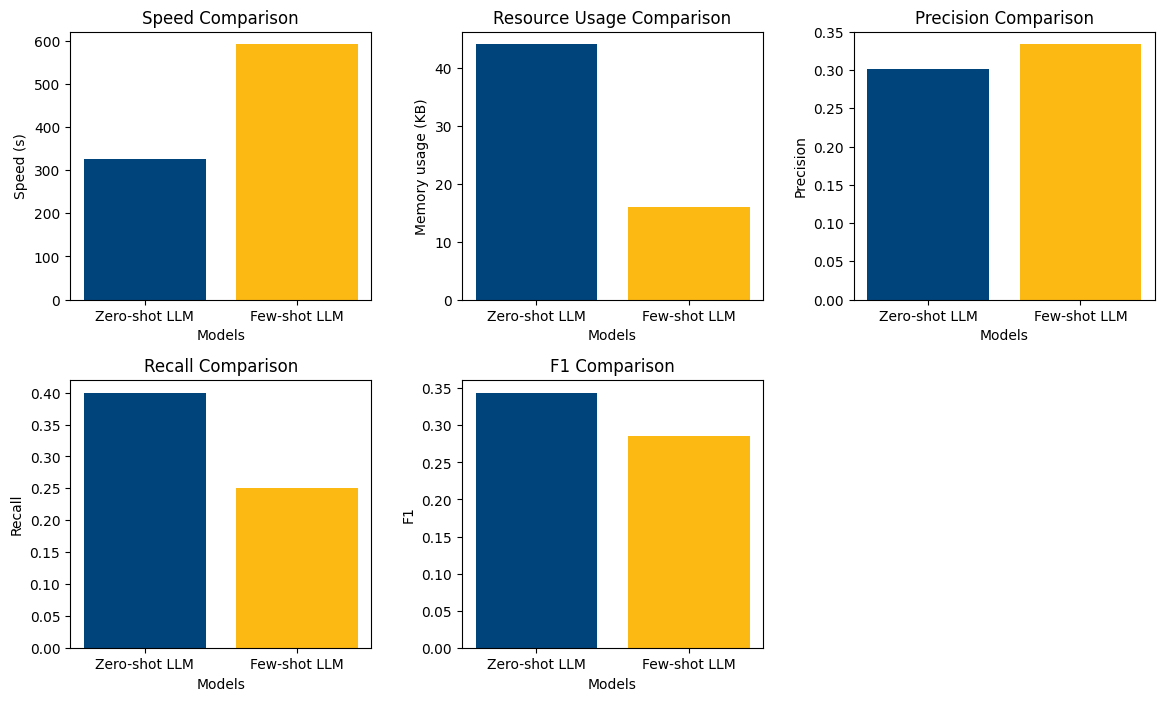

In [113]:
vizualization_labels = {'speed': {'title': 'Speed Comparison', 'y': 'Speed (s)', 'plot_num': 1},
                        'resource usage': {'title': 'Resource Usage Comparison', 'y': 'Memory usage (KB)', 'plot_num': 2}, 
                        'Precision': {'title': 'Precision Comparison', 'y': 'Precision', 'plot_num': 3},
                        'Recall': {'title':  'Recall Comparison', 'y': 'Recall', 'plot_num': 4},
                        'F1': {'title': 'F1 Comparison', 'y': 'F1', 'plot_num': 5}}

model_names = ['Zero-shot LLM', 'Few-shot LLM']
colors = ['#00447c', '#fdb913']

visualize_comparision(model_names, vizualization_labels, colors, rows = 2, cols = 3)

Obtained results indicate that in this case:
- The Zero-shot LLM was faster than the Few-shot LLM. It had less commands to analyze,
- The Zero-shot LLM used more resources (KB) compared to the Few-shot LLM. This could be due to the Zero-shot model using more memory to handle the raw complexity of performing the task without prior examples,
- The Few-shot LLM had higher precision than the Zero-shot LLM. The Few-shot model might perform better because the examples provided in the prompt help the model to better understand the context and make more accurate predictions.
- The Zero-shot LLM had higher recall than the Few-shot LLM,
- The Zero-shot LLM had a higher F1 score than the Few-shot LLM.

Summarizing all the compared metrics, a conclusion can be made that the Zero-shot model was faster and tended to find more relevant entities, but it may be more prone to false positives. In contrast, the Few-shot model was more accurate, when it came to precision, but it missed some relevant entities. 
The higher F1 score for the Zero-shot model indicates that, despite having lower precision, it strides a better balance between precision and recall in this particular task.

## Task 6

Compare results between:
   * Traditional NER (SpaCy)
   * Pure LLM-based approach

In [114]:
models_performances_df

,SpaCy,Zero-shot LLM,Few-shot LLM
speed,0.269781,325.281893,592.069935
resource usage,20.000000,44.000000,16.000000
COR,10.000000,16.000000,10.000000
INC,6.000000,3.000000,3.000000
MIS,24.000000,21.000000,27.000000
SPU,13.000000,34.000000,17.000000
POS,40.000000,40.000000,40.000000
ACT,29.000000,53.000000,30.000000
Precision,0.344828,0.301887,0.333333
Recall,0.250000,0.400000,0.250000


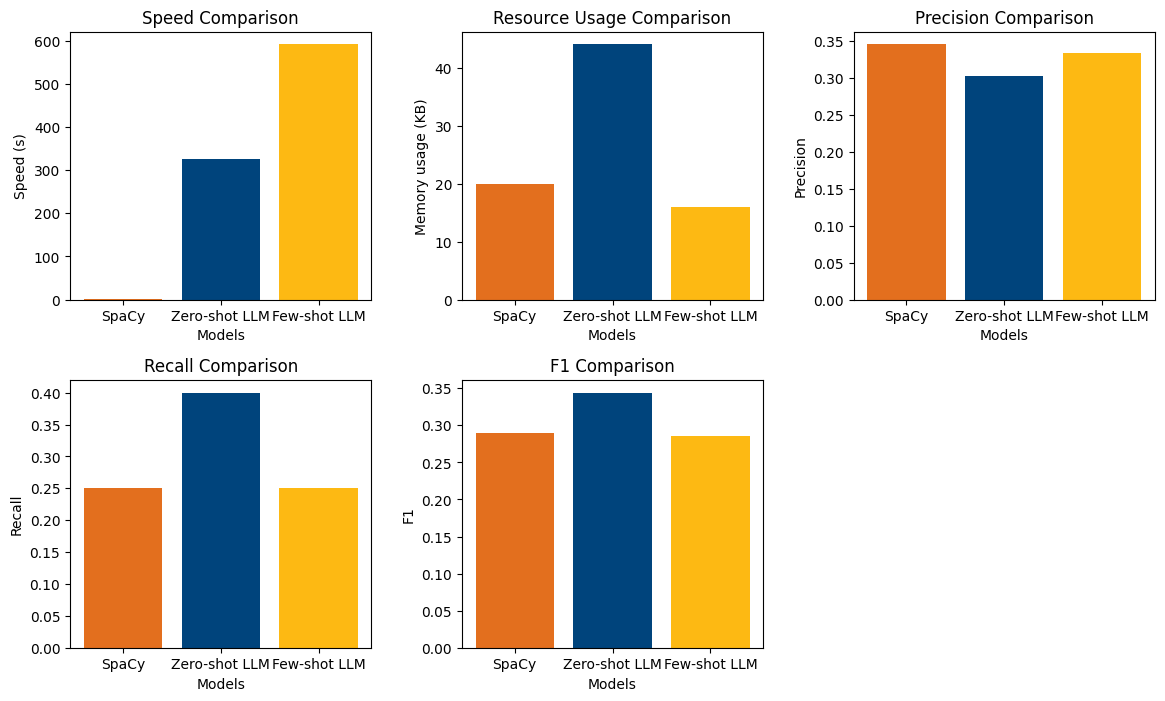

In [115]:
model_names = ['SpaCy', 'Zero-shot LLM', 'Few-shot LLM']
colors = ['#e36f1e', '#00447c', '#fdb913']
visualize_comparision(model_names, vizualization_labels, colors, rows = 2, cols = 3)

In this task, I compare results between Traditional NER (SpaCy) and both variants of LLM (Gemma2). I assume these variants fall under the term 'Pure LLM-based approach'.

The obtained results indicate that, in this case:
- Traditional NER (SpaCy) significantly outperformed both LLM models in terms of speed (the measurement is so small that it is barely noticeable). It is normal situation, because SpaCy is a task-specific model fine-tuned for NER, which makes it optimized and efficient for this task. In contrast gemma2 s  general-purpose mo, what resulted in worser resultsdel,
- Traditional NER (SpaCy) with Few-shot LLM used least resources among the compared models. The difference between Traditional NER (SpaCy) and the Zero-shot LLM is significant.
- Traditional NER (SpaCy) achieved the highest precision among the compared models, being more precise than the Few-shot LLM. It is easy explainable as SpaCy is a specialized model for NER,
- Surprisingly, Traditional NER (SpaCy) returned a lower recall than the Zero-shot LLM. It seems that Zero-shot LLM caught more entities due to its general undestanding of language,
- In terms of F1 score, Traditional NER (SpaCy) and the Few-shot LLM had similar results lower than Zero-shot LLM.

## Task 7

Build a simple evaluation pipeline:
   * Manually annotate 20 passages for ground truth (ideally, share those annotated passages in the group, so everyone have much more than 20)
   * Compute precision, recall, and F1 score for each approach
   * Analyze error patterns and classification mistakes

I have already manually annotated 20 passages for the ground truth in Task 3. I have also computed: precision, recall and F1 score for each approach. Now, I am going to focus on error pattern analysis and classification mistakes. Some of the previously gathered results may be helpful.

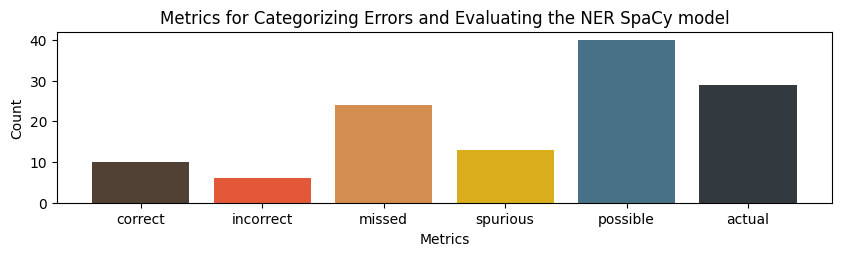

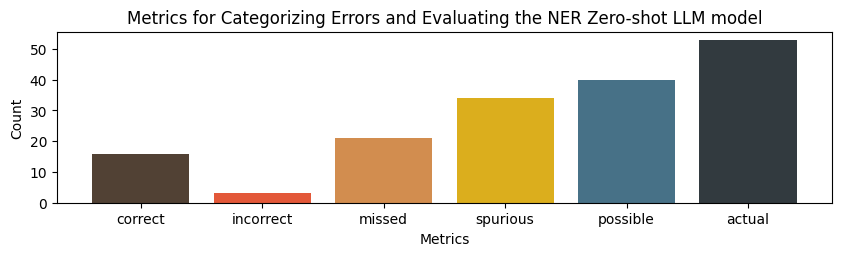

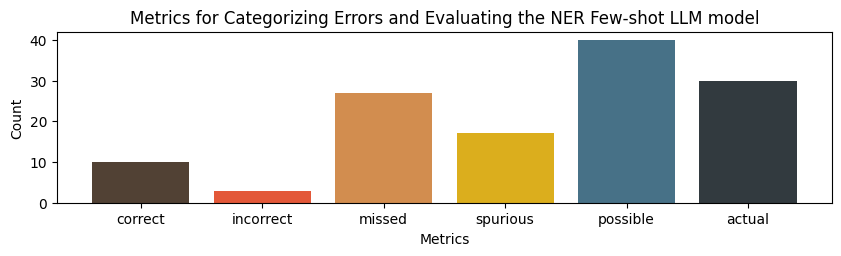

In [116]:
model_names = ['SpaCy', 'Zero-shot LLM', 'Few-shot LLM']
metrics = ['correct', 'incorrect', 'missed', 'spurious', 'possible', 'actual']
colors = ['#514134', '#e35839', '#d28d4f', '#dbae1d', '#477187', '#323a3f']
plt.rcParams['figure.figsize'] = [10, 8]

for model_name in model_names:
    plt.subplot(3, 1, model_names.index(model_name) + 1)
    plt.bar(metrics, [int(x) for x in models_performances_df[model_name][2:8]], color = colors)
    plt.xlabel('Metrics') 
    plt.ylabel('Count') 
    plt.title(f'Metrics for Categorizing Errors and Evaluating the NER {model_name} model') 
    plt.subplots_adjust(hspace = 0.3)
    plt.show()

The analysis of error patterns and classification mistakes reveals several important insights. Across all models, the number of incorrect classifications (INC) was the lowest among the metrics suggesting errors. It was uncommon for a situation to arise where both a ground truth entity and a predicted entity were present but not exactly the same. The results show that the primary issue was not the mismatch of similar entities, but rather the models inability to correctly identify true entities.

High missed classifications (MIS) demonstrate that many true entities were not captured at all. At the same time, the models frequently identified entities that did not correspond to any true entities, as reflected in the high number of spurious classifications (SPU). This over-predictive behavior was particularly notable in the Zero-shot LLM, which tended to generate false positives by identifying non-existent entities.

Summarizing theses findings, the models faced two major challenges: failing to detect true entities and predicting non-existent entition.

## Questions

### Question 1

How does the performance of LLM-based NER compare to traditional approaches? What are the trade-offs in terms of accuracy, speed, and resource usage?

In my opinion, traditional NER (SpaCy) significantly outperformed both LLM models in terms of speed. Resource usage for NER (SpaCy) and Few-shot LLM was lower than Zero-shot LLM. Traditional NER was also quite more precesive than Few-shot LLM. Based on previous interpretations of results, I can conclude that traditional NER offers several trade-offs. Firstly, traditional NER systems are far superior in terms of speed, making them the preferred choice for applications where latency is critical. They are also resource-efficient, which makes them ideal for environments with limited computational capacity. While LLMs tend to have better accuracy in open-domain or low-resource settings, traditional models often outperform them in structured or domain-specific tasks.

### Question 2

Which prompting strategy proved most effective for NER and classification tasks? Why?

Few-shot prompting proved to be the most effective for NER and classification tasks due to its ability to guide the model with clear examples. Although Zero-shot prompting was fast and required no examples, it was often less precesive, especially in complex tasks, where the model needed contextual understanding to correctly identify and classify entities.

### Question 3

What are the limitations and potential biases of using LLMs for NER and classification?

The chosen LLMs for NER turned out to be unstable and unreliable. Responses from LLMs can be inconsistent, even with the same prompt, due to their probabilistic nature. This inconsistency can result in unpredictable behavior that affects running code. LLMs are also resource-intensive, making them costly to use. Another limitation of LLMs is that their performance can degrade, if the input text is too long or contains complex interdependencies. They may generate spurious entities or classifications that are not grounded in the input text. This was a real problem in my model and only a complex prompt partially mitigated the issue. Additionally, customizability is a barrier, as users often have to rely on trial-and-error methods during prompt design without any guarantee of improved results.

Several biases are worth mentioning. Firstly, there is language and regional bias, as LLMs tend to perform better in widely spoken languages like English. Moreover, the design of prompts can unintentionally introduce biases. For instance, the phrasing of a prompt might lead the model to focus on certain entity types while ignoring others.

Another source of bias stems from the training data. LLMs are trained on vast datasets, but imbalanced data can lead to poor performance on underrepresented entities, topics, or categories. LLMs may also fail to recognize domain-specific entities because their training data prioritizes general knowledge.

### Question 4

In what scenarios would you recommend using traditional NER vs. LLM-based approaches?


Traditional NER is highly suitable for high-speed applications like real-time chatbots. These models are also a great choice for resource-constrained environments due to their minimal computational requirements. Additionally, traditional NER performs effectively, when extracting entities like names or dates from structured documents.

In contrast, LLM-based approaches have distinct applications compared to traditional NER. LLMs are particularly valuable for tasks requiring multilingual or cross-domain capabilities. They excel in applications such as chatbots, where advanced contextual understanding or handling of ambiguous text is required. Furthermore, in scenarios involving complex or nuanced information, leveraging large, well-trained models becomes a preferable choice.